In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import cholesky, solve_triangular

import modmcmc as mm
from Gaussian import Gaussian
from helper import get_col_hist_grid

In [3]:
rng = np.random.default_rng(532124)

# Set up linear Gaussian inverse problem and forward model emulator

In [27]:
# Linear Gaussian inverse problem

# Parameter and observation dimension
d = 2
n = 20

# Prior
m = rng.normal(size=d)
C_sqrt = rng.normal(size=(d,d))
C = C_sqrt @ C_sqrt.T
u = Gaussian(mean=m, cov=C, rng=rng)

# Linear forward model
G = rng.normal(size=(n,d))

# Noise covariance
Sig_sqrt = rng.normal(size=(n,n))
Sig = Sig_sqrt @ Sig_sqrt.T
noise = Gaussian(cov=Sig, rng=rng)

# Data
y = G @ u.sample().T + noise.sample().T
y = y.flatten()

In [28]:
# Forward model emulator of the form f_star(u) = f(u) + e, e ~ N(r, Q)
q_scale = 0.1
r = 2*np.ones(n) # rng.normal(size=n)
Q_sqrt = q_scale * rng.normal(size=(n,n))
Q = Q_sqrt @ Q_sqrt.T
e = Gaussian(mean=r, cov=Q, rng=rng)

# Helper functions to compute closed-form EP and EUP distributions

In [29]:
def get_ep_rv(y, u, G, Sig, e):
    u_post = u.invert_affine_Gaussian(y, A=G, cov_noise=Sig, store="both")
    L_Sig = cholesky(Sig, lower=True)
    C1 = solve_triangular(L_Sig, G, lower=True)
    C2 = solve_triangular(L_Sig.T, C1, lower=False)    
    B = -u_post.cov @ C2.T    
    u_ep = e.convolve_with_Gaussian(A=B, b=u_post.mean, cov_new=u_post.cov)
    return u_ep

def get_eup_rv(y, u, G, Sig, e):
    u_eup = u.invert_affine_Gaussian(y, A=G, b=e.mean, cov_noise=Sig+e.cov)
    return u_eup

# Compare distributions

In [30]:
u_post = u.invert_affine_Gaussian(y, A=G, cov_noise=Sig)
u_ep = get_ep_rv(y, u, G, Sig, e)
u_eup = get_eup_rv(y, u, G, Sig, e)

In [31]:
n_samp = 100000
samp_post = u_post.sample(n_samp)
samp_ep = u_ep.sample(n_samp)
samp_eup = u_eup.sample(n_samp)

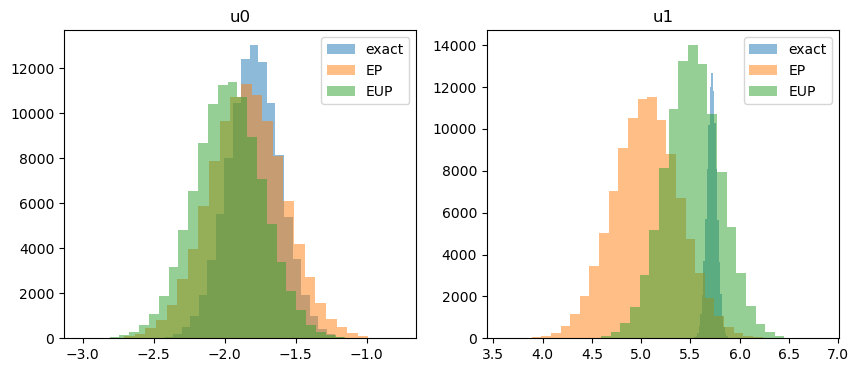

In [32]:
hist_plt = get_col_hist_grid(samp_post, samp_ep, samp_eup, bins=30, nrows=1, 
                             col_labs=["u0", "u1"], plot_labs=["exact", "EP", "EUP"])
plt.show()